In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit
from scipy.ndimage import label, binary_dilation
import pandas as pd
from scipy.interpolate import interp1d

## Data Import:

In [2]:
image = "/Users/sujoy7471/Research_Env/3rdSem_Break/SBF/Test/M85/j8fs05020/j8fs05021_drc.fits"
hdul = fits.open(image)
print("EXPTIME =", fits.open(image)[0].header["EXPTIME"])
exp_time = fits.open(image)[0].header["EXPTIME"]

EXPTIME = 750.0


In [3]:
for k in ["DATE-OBS", "TIME-OBS", "EXPSTART", "EXPEND", "MJD-OBS"]:
    print(k, hdul[0].header.get(k))

DATE-OBS 2003-02-01
TIME-OBS None
EXPSTART 52671.89466465
EXPEND 52671.90493122
MJD-OBS None


In [4]:
hdul.info()
sci = hdul["SCI"].data
# sci = np.flipud(sci)   # Flip axes for correct calculations

wht = hdul["WHT"].data   # inverse variance map
hdr = hdul["SCI"].header

hdul.close()

Filename: /Users/sujoy7471/Research_Env/3rdSem_Break/SBF/Test/M85/j8fs05020/j8fs05021_drc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     778   ()      
  1  SCI           1 ImageHDU        87   (4213, 4237)   float32   
  2  WHT           1 ImageHDU        44   (4213, 4237)   float32   
  3  CTX           1 ImageHDU        37   (4213, 4237)   int32   
  4  HDRTAB        1 BinTableHDU    595   4R x 293C   [9A, 3A, K, D, D, D, D, D, D, D, D, D, D, D, D, D, K, 3A, 9A, 7A, 18A, 4A, D, D, D, D, 3A, D, D, D, D, D, D, D, D, D, D, D, D, K, 8A, 23A, D, D, D, D, K, K, K, 8A, K, 23A, 9A, 20A, K, 4A, K, K, K, K, K, K, 23A, D, D, D, D, K, K, 3A, 3A, 4A, 7A, L, D, D, D, 23A, 1A, K, D, D, D, 24A, 3A, 4A, 4A, 12A, 12A, 23A, 8A, 23A, 10A, 10A, D, D, 3A, 3A, 23A, 4A, 8A, 7A, 23A, D, K, D, 6A, 9A, 8A, D, D, L, 4A, 18A, 3A, K, 5A, 7A, 3A, D, 13A, 8A, 4A, 3A, L, K, L, K, L, K, K, D, D, D, D, D, D, 3A, 1A, D, 23A, D, D, D, 3A, 23A, L, 1A, 3A, 1A, D, 3A

In [5]:
PHOTZPT = hdr["PHOTZPT"]
PHOTFLAM = hdr["PHOTFLAM"]


print("PHOTZPT =", PHOTZPT)
print("PHOTFLAM = ", PHOTFLAM)

PHOTZPT = -21.1
PHOTFLAM =  1.8016764e-19


In [6]:
with fits.open(image) as hdul:
    hdr = hdul["SCI"].header

    exptime = hdr.get("EXPTIME")
    bunit    = hdr.get("BUNIT")
    photflam = hdr.get("PHOTFLAM")
    photzpt  = hdr.get("PHOTZPT")
    photmode = hdr.get("PHOTMODE")

print("EXPTIME  =", exptime)
print("BUNIT    =", bunit)
print("PHOTFLAM =", photflam)
print("PHOTZPT  =", photzpt)
print("PHOTMODE =", photmode)


EXPTIME  = None
BUNIT    = ELECTRONS/S
PHOTFLAM = 1.8016764e-19
PHOTZPT  = -21.1
PHOTMODE = ACS WFC1 F475W MJD#52671.8947


In [7]:
from astroquery.simbad import Simbad
result = Simbad.query_region(
    f"{hdr['CRVAL1']} {hdr['CRVAL2']}",
    radius="2m"
)
print(result)


            main_id                      ra         ...     coo_bibcode    
                                        deg         ...                    
-------------------------------- ------------------ ... -------------------
           [JCF90] NGC  4382  14 186.34479166666665 ...                    
[JPB2009] 186.3561418+18.1637190        186.3561418 ... 2009ApJS..180...54J
[JPB2009] 186.3619145+18.1625082        186.3619145 ... 2009ApJS..180...54J
[JPB2009] 186.3495663+18.1635194        186.3495663 ... 2009ApJS..180...54J
[JPB2009] 186.3508293+18.1627581        186.3508293 ... 2009ApJS..180...54J
[JPB2009] 186.3511337+18.1636097        186.3511337 ... 2009ApJS..180...54J
           [JCF90] NGC  4382  68 186.36024999999998 ...                    
           [JCF90] NGC  4382  76 186.36979166666666 ...                    
           [JCF90] NGC  4382  42 186.33587500000002 ...                    
                             ...                ... ...                 ...
           [

In [8]:
for key in ["FILTER", "FILTER1", "FILTER2"]:
    if key in hdr:
        print(key, "=", hdr[key])

for k in hdr:
    if "PHOT" in k or "FILTER" in k:
        print(k, hdr[k])


print(hdr["PHOTMODE"])


PHOTMODE ACS WFC1 F475W MJD#52671.8947
PHOTFLAM 1.8016764e-19
PHOTZPT -21.1
PHOTPLAM 4745.644
PHOTBW 420.10065
ACS WFC1 F475W MJD#52671.8947


<function matplotlib.pyplot.show(close=None, block=None)>

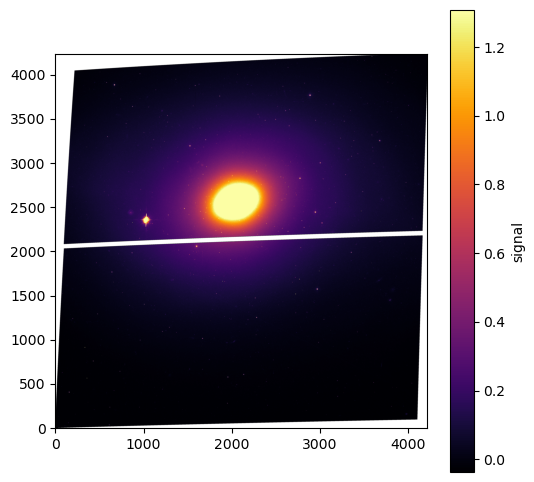

In [9]:
mask = ~np.isfinite(sci)   # True where NaN or inf

sci_masked = np.ma.array(sci, mask=mask)

vmin = np.percentile(sci_masked.compressed(), 5)
vmax = np.percentile(sci_masked.compressed(), 99)


plt.figure(figsize=(6, 6))
plt.imshow(sci_masked, origin="lower", cmap="inferno", vmin=vmin, vmax=vmax)
plt.colorbar(label="signal")
plt.show

## Sersic fit and continuum subtraction:

Gaussian fit parameters:
Amplitude a   = 15.226
Sigma_x       = 75.747
Sigma_y       = 56.934
x0 (peak)     = 2045.550
y0 (peak)     = 2557.947
Theta (rad)   = 16.110
Theta (rad) (in 0, 2pi)   = 3.543415


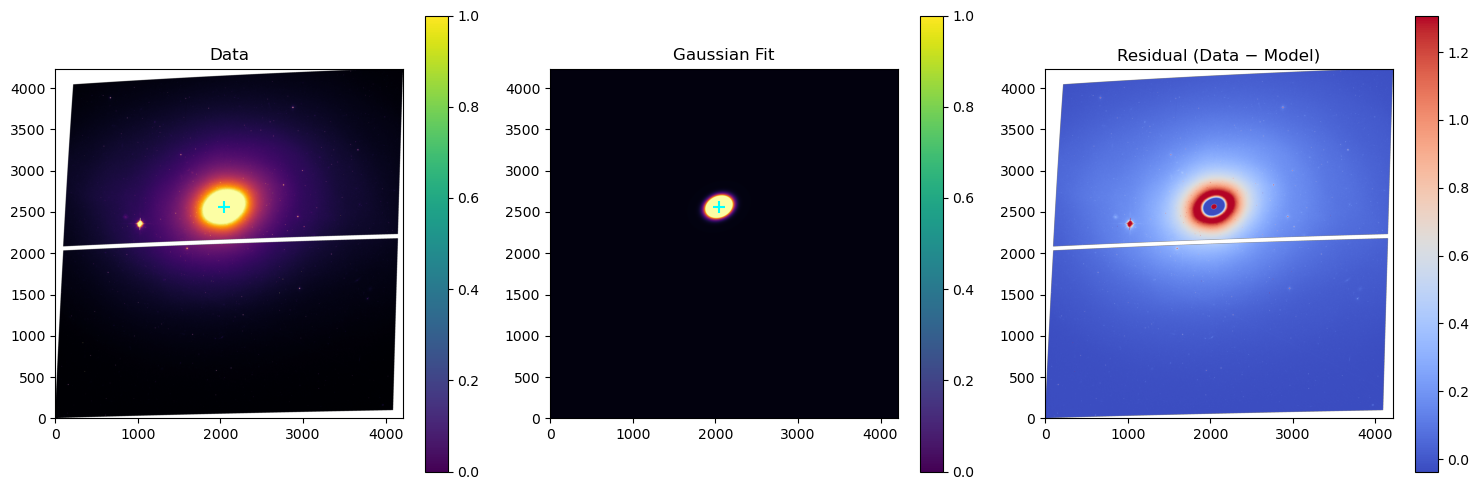

In [10]:
##Find the rough parameters using gaussian fit to help the sersic fit parameters:
def gaussian2d(axes, a, sigma_x, sigma_y, x0, y0, theta):
    x, y = axes

    # shift to center
    xp = x - x0
    yp = y - y0

    # rotation
    cos_t = np.cos(theta)
    sin_t = np.sin(theta)

    x_rot =  cos_t * xp + sin_t * yp
    y_rot = -sin_t * xp + cos_t * yp

    return a * np.exp(
        -0.5 * (
            (x_rot / sigma_x)**2 +
            (y_rot / sigma_y)**2
        )
    )

ny, nx = sci.shape
y, x = np.mgrid[0:ny, 0:nx]


mask = sci_masked.mask

x_fit = x[~mask]
y_fit = y[~mask]

x0_i, y0_i = 2300, 1700        ##Guess by looking
sigma_x_i = 103
sigma_y_i = 117
a_i = 24.5
theta_i = 10

initial_guess = [a_i, sigma_x_i, sigma_y_i, x0_i, y0_i, theta_i]
z_fit = sci_masked.data[~sci_masked.mask]

popt, pcov = curve_fit(
    gaussian2d,
    (x_fit, y_fit),
    z_fit,
    p0=initial_guess,
    maxfev=20000
)


a, sigma_x, sigma_y, x0, y0, _ = np.abs(popt)     ##Sometimes gives negative parameters
theta = popt[-1]



# -------------------------------------------------
# Print fitted parameters
# -------------------------------------------------
print("Gaussian fit parameters:")
print(f"Amplitude a   = {a:.3f}")
print(f"Sigma_x       = {sigma_x:.3f}")
print(f"Sigma_y       = {sigma_y:.3f}")
print(f"x0 (peak)     = {x0:.3f}")
print(f"y0 (peak)     = {y0:.3f}")
print(f"Theta (rad)   = {theta:.3f}")
print(f"Theta (rad) (in 0, 2pi)   = {np.mod(theta, 2*np.pi):.6f}")


# -------------------------------------------------
# Reconstruct full fitted model on the grid
# -------------------------------------------------
model_full = gaussian2d((x, y), a, sigma_x, sigma_y, x0, y0, theta)

# Residual (only meaningful where data is valid)
residual = np.zeros_like(sci, dtype=float)
residual[~mask] = sci_masked.data[~mask] - model_full[~mask]
residual = np.ma.array(residual, mask=mask)

# -------------------------------------------------
# Plot: data, model, residual
# -------------------------------------------------
vmin, vmax = np.nanpercentile(sci_masked.compressed(), [5, 99])

plt.figure(figsize=(15, 5))

# --- Data ---
plt.subplot(1, 3, 1)
plt.title("Data")
plt.imshow(sci_masked, origin="lower", cmap="inferno",
           vmin=vmin, vmax=vmax)
plt.scatter(x0, y0, c="cyan", s=80, marker="+")
plt.colorbar()

# --- Model ---
plt.subplot(1, 3, 2)
plt.title("Gaussian Fit")
plt.imshow(model_full, origin="lower", cmap="inferno",
           vmin=vmin, vmax=vmax)
plt.scatter(x0, y0, c="cyan", s=80, marker="+")
plt.colorbar()

# --- Residual ---
plt.subplot(1, 3, 3)
plt.title("Residual (Data − Model)")
plt.imshow(residual, origin="lower", cmap="coolwarm", vmin=vmin, vmax=vmax)
plt.colorbar()

plt.tight_layout()
plt.show()


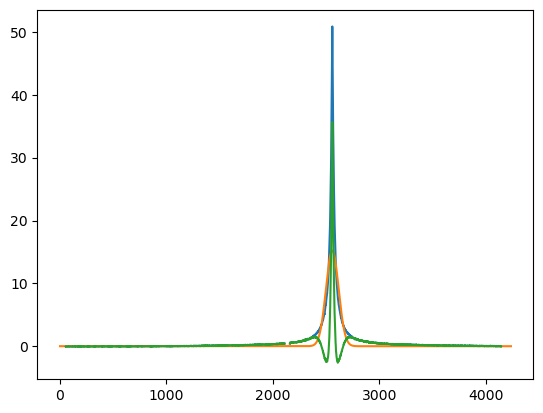

In [11]:
plt.plot(sci_masked[:,int(x0)])
plt.plot(model_full[:,int(x0)])
plt.plot(residual[:, int(x0)])
plt.show()

In [12]:
# --------------------------------------------
# Crop the image based on Gaussian fit
# --------------------------------------------
sigma_max = max(sigma_x, sigma_y)

gu = 7                                         #Parameter to select size of the image in terms of sigma of the gaussian (max one)
R_crop = abs(int(gu * sigma_max))

ny, nx = sci_masked.shape

x0_i = int(abs(x0))
y0_i = int(abs(y0))

x_min = max(x0_i - R_crop, 0)
x_max = min(x0_i + R_crop, nx)

y_min = max(y0_i - R_crop, 0)
y_max = min(y0_i + R_crop, ny)

sci_cropped_masked = sci_masked[y_min:y_max, x_min:x_max]

In [13]:
#Check fo valid selection
compressed = sci_cropped_masked.compressed()

print("Number of valid pixels in crop:", compressed.size)


Number of valid pixels in crop: 1069916


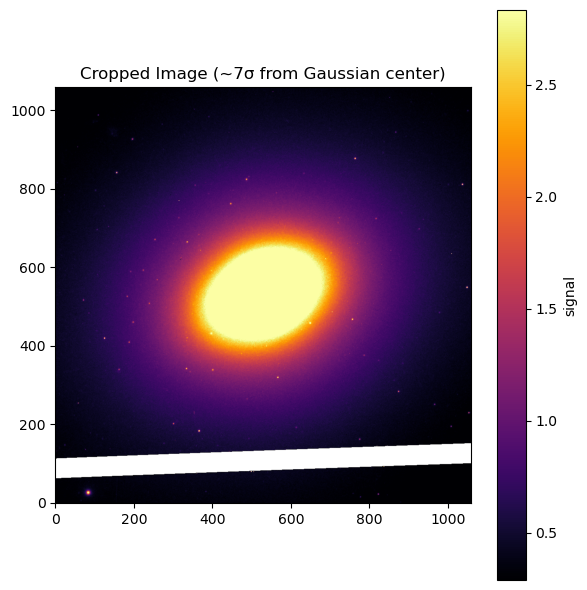

In [14]:
vmin, vmax = np.nanpercentile(sci_cropped_masked.compressed(), [5, 95])

plt.figure(figsize=(6, 6))
plt.title(f"Cropped Image (~{gu}σ from Gaussian center)")
plt.imshow(sci_cropped_masked, origin="lower",cmap="inferno", vmin=vmin, vmax=vmax)


plt.colorbar(label="signal")
plt.tight_layout()
plt.show()

In [15]:
def sersic2d_bg(axes, I0, Re, n, x0, y0, q, theta, c):
    x, y = axes

    xp = x - x0
    yp = y - y0

    ct = np.cos(theta)
    st = np.sin(theta)

    x_rot =  ct * xp + st * yp
    y_rot = -st * xp + ct * yp

    R = np.sqrt(x_rot**2 + (y_rot / q)**2)
    R = np.maximum(R, 1e-6)

    bn = 2*n - 1/3                       ##Constrain parameter condition

    return I0 * np.exp(-bn * ((R / Re)**(1/n) - 1)) + c


ny_c, nx_c = sci_cropped_masked.shape
y_c, x_c = np.mgrid[y_min:y_max, x_min:x_max]

mask_c = sci_cropped_masked.mask
x_fit = x_c[~mask_c]
y_fit = y_c[~mask_c]
z_fit = sci_cropped_masked.data[~mask_c]


I0_i = np.percentile(z_fit, 90)
Re_i = abs(sigma_x)
n_i  = 3.0
q_i  = abs(min(sigma_y / sigma_x, 0.9))
theta_i = 7
c = np.median(z_fit)

p0 = [I0_i, Re_i, n_i, x0, y0, q_i, theta_i, c]

bounds = (
    [0,    5,   0.5, x0-10, y0-10, 0.1, -4*np.pi, -1],
    [1e6, 3000, 8.0, x0+10, y0+10, 1.0, 4*np.pi, 1]
)


popt, pcov = curve_fit(
    sersic2d_bg,
    (x_fit, y_fit),
    z_fit,
    p0=p0,
    maxfev=80000
)

I0, Re, n, x0_s, y0_s, q, theta_s, c = popt

In [16]:
model_cropped = sersic2d_bg((x_c, y_c), *popt)

residual_cropped = np.zeros_like(sci_cropped_masked.data)
residual_cropped[~mask_c] = ( sci_cropped_masked.data[~mask_c] - model_cropped[~mask_c] )
residual_cropped = np.ma.array(residual_cropped, mask=mask_c)

In [17]:
print("\nSérsic + background fit parameters:")
print(f"I0           = {I0:.4f}")
print(f"Re           = {Re:.4f}  (pixels)")
print(f"Sérsic n     = {n:.4f}")
print(f"x0           = {x0_s:.4f}")
print(f"y0           = {y0_s:.4f}")
print(f"Axis ratio q = {q:.4f}")
print(f"Theta (rad)  = {np.mod(theta_s, 2*np.pi):.4f}")
print(f"Theta (deg)  = {np.degrees(np.mod(theta_s, 2*np.pi)):.4f}")
print(f"Background   = {c:.4f}")
# print(f"Background C= {C:.4f}")



Sérsic + background fit parameters:
I0           = 1.5286
Re           = 200.0416  (pixels)
Sérsic n     = 2.2567
x0           = 2045.4218
y0           = 2557.9194
Axis ratio q = 0.7692
Theta (rad)  = 0.4040
Theta (deg)  = 23.1490
Background   = 0.3152


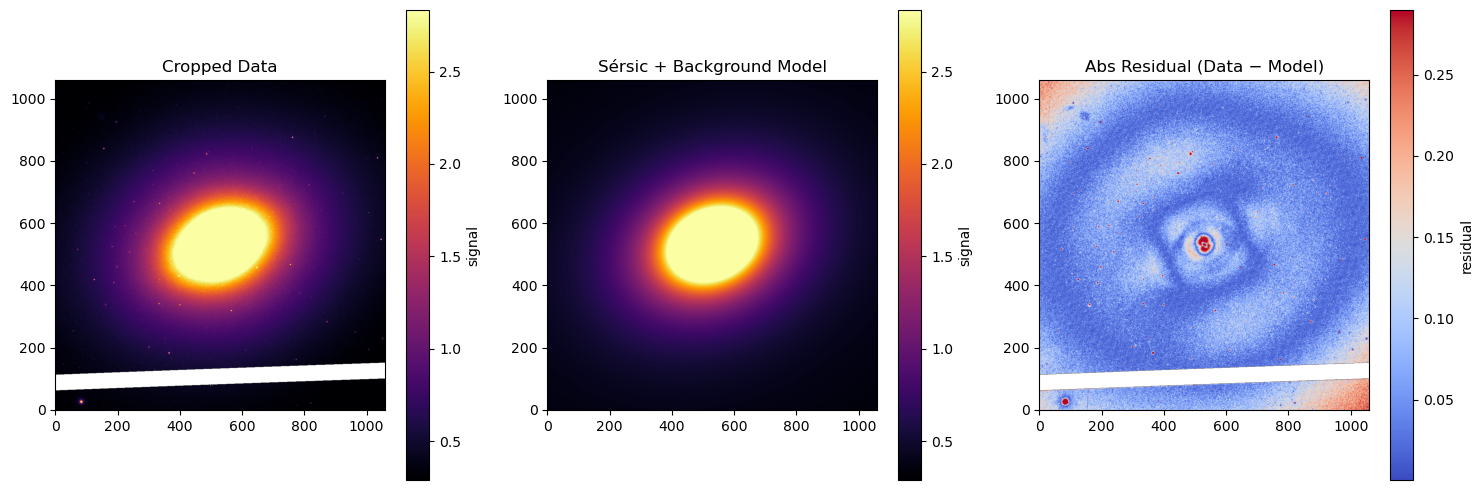

In [18]:
vmin, vmax = np.nanpercentile(sci_cropped_masked.compressed(), [5, 95])

plt.figure(figsize=(15, 5))

# --- Data ---
plt.subplot(1, 3, 1)
plt.title("Cropped Data")
plt.imshow(sci_cropped_masked, origin="lower", cmap="inferno", vmin=vmin, vmax=vmax )
plt.colorbar(label="signal")

# --- Model ---
plt.subplot(1, 3, 2)
plt.title("Sérsic + Background Model")
plt.imshow( model_cropped, origin="lower", cmap="inferno", vmin=vmin, vmax=vmax)
plt.colorbar(label="signal")

# --- Residual ---
plt.subplot(1, 3, 3)
plt.title("Abs Residual (Data − Model)")
plt.imshow( np.abs(residual_cropped/model_cropped**0.5), origin="lower", cmap="coolwarm", vmin=vmin, vmax=0.0005)
plt.colorbar(label="residual")

plt.tight_layout()
plt.show()


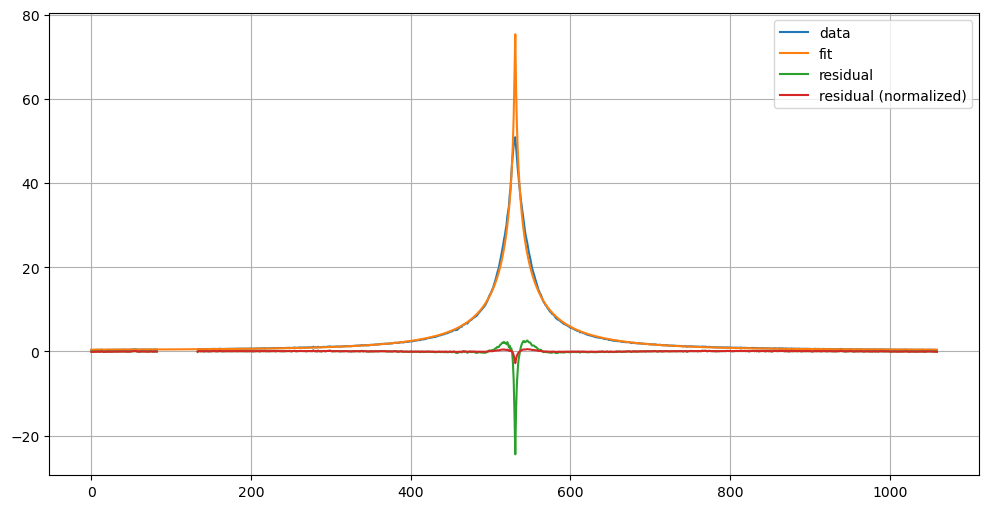

In [19]:
plt.figure(figsize = (12, 6))
plt.plot(sci_cropped_masked[:, int(gu*sigma_max)], label = "data")
plt.plot(model_cropped[:, int(gu*sigma_max)], label = "fit")
plt.plot(residual_cropped[:, int(gu*sigma_max)], label = "residual")
plt.plot(residual_cropped[:, int(gu*sigma_max)]/model_cropped[:, int(gu*sigma_max)]**0.5, label = "residual (normalized)")
plt.legend()
plt.grid()
plt.show()

### Masking the background sources:

In [20]:
# --------------------------------------------
# Elliptical annulus mask (Central mask)
# --------------------------------------------
ny, nx = sci_cropped_masked.shape
y, x = np.mgrid[0:ny, 0:nx]

# Shift coordinates to center
xp = x - int(abs(gu*sigma_max))
yp = y - int(abs(gu*sigma_max))

# Sérsic geometry
ct = np.cos(theta)             ##IDK where was the inconsistancy but - worked and thus I have addopted that :)
st = np.sin(theta)

# Rotate coordinates
x_rot =  ct * xp + st * yp
y_rot = -st * xp + ct * yp

# Elliptical radius
r_ell = np.sqrt(x_rot**2 + (y_rot / q)**2)

# Define annulus (in pixels)              ##Just my choice. This worked for the image. It successfully covers the central region and also faint signals
r_in  = 0.5 * Re
r_out = 2.50 * Re

annulus_mask = (r_ell >= r_in) & (r_ell < r_out)


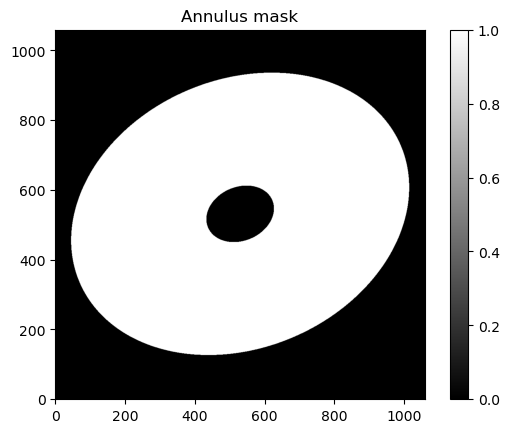

In [21]:
plt.imshow(annulus_mask, origin="lower", cmap="gray")
plt.colorbar()
plt.title("Annulus mask")
plt.show()


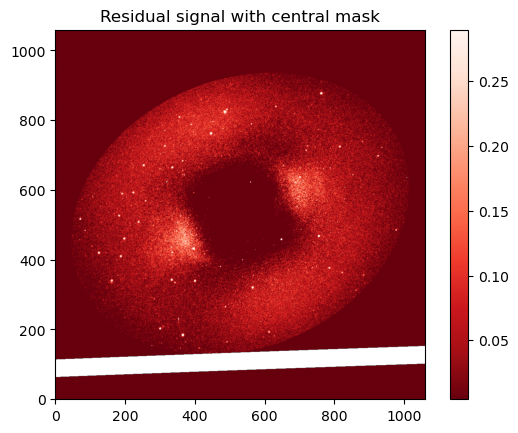

In [22]:
sbf_image = np.zeros_like(residual_cropped/model_cropped**0.5)
sbf_image[annulus_mask] = residual_cropped[annulus_mask]

plt.imshow((sbf_image), origin="lower", cmap="Reds_r", vmin=vmin, vmax=0.005)
plt.colorbar()
plt.title("Residual signal with central mask")
plt.show()


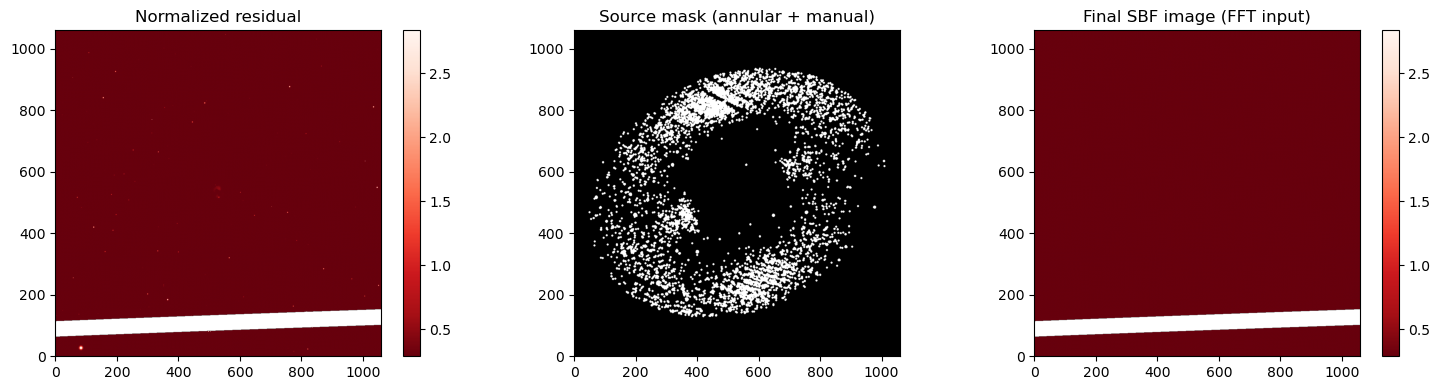

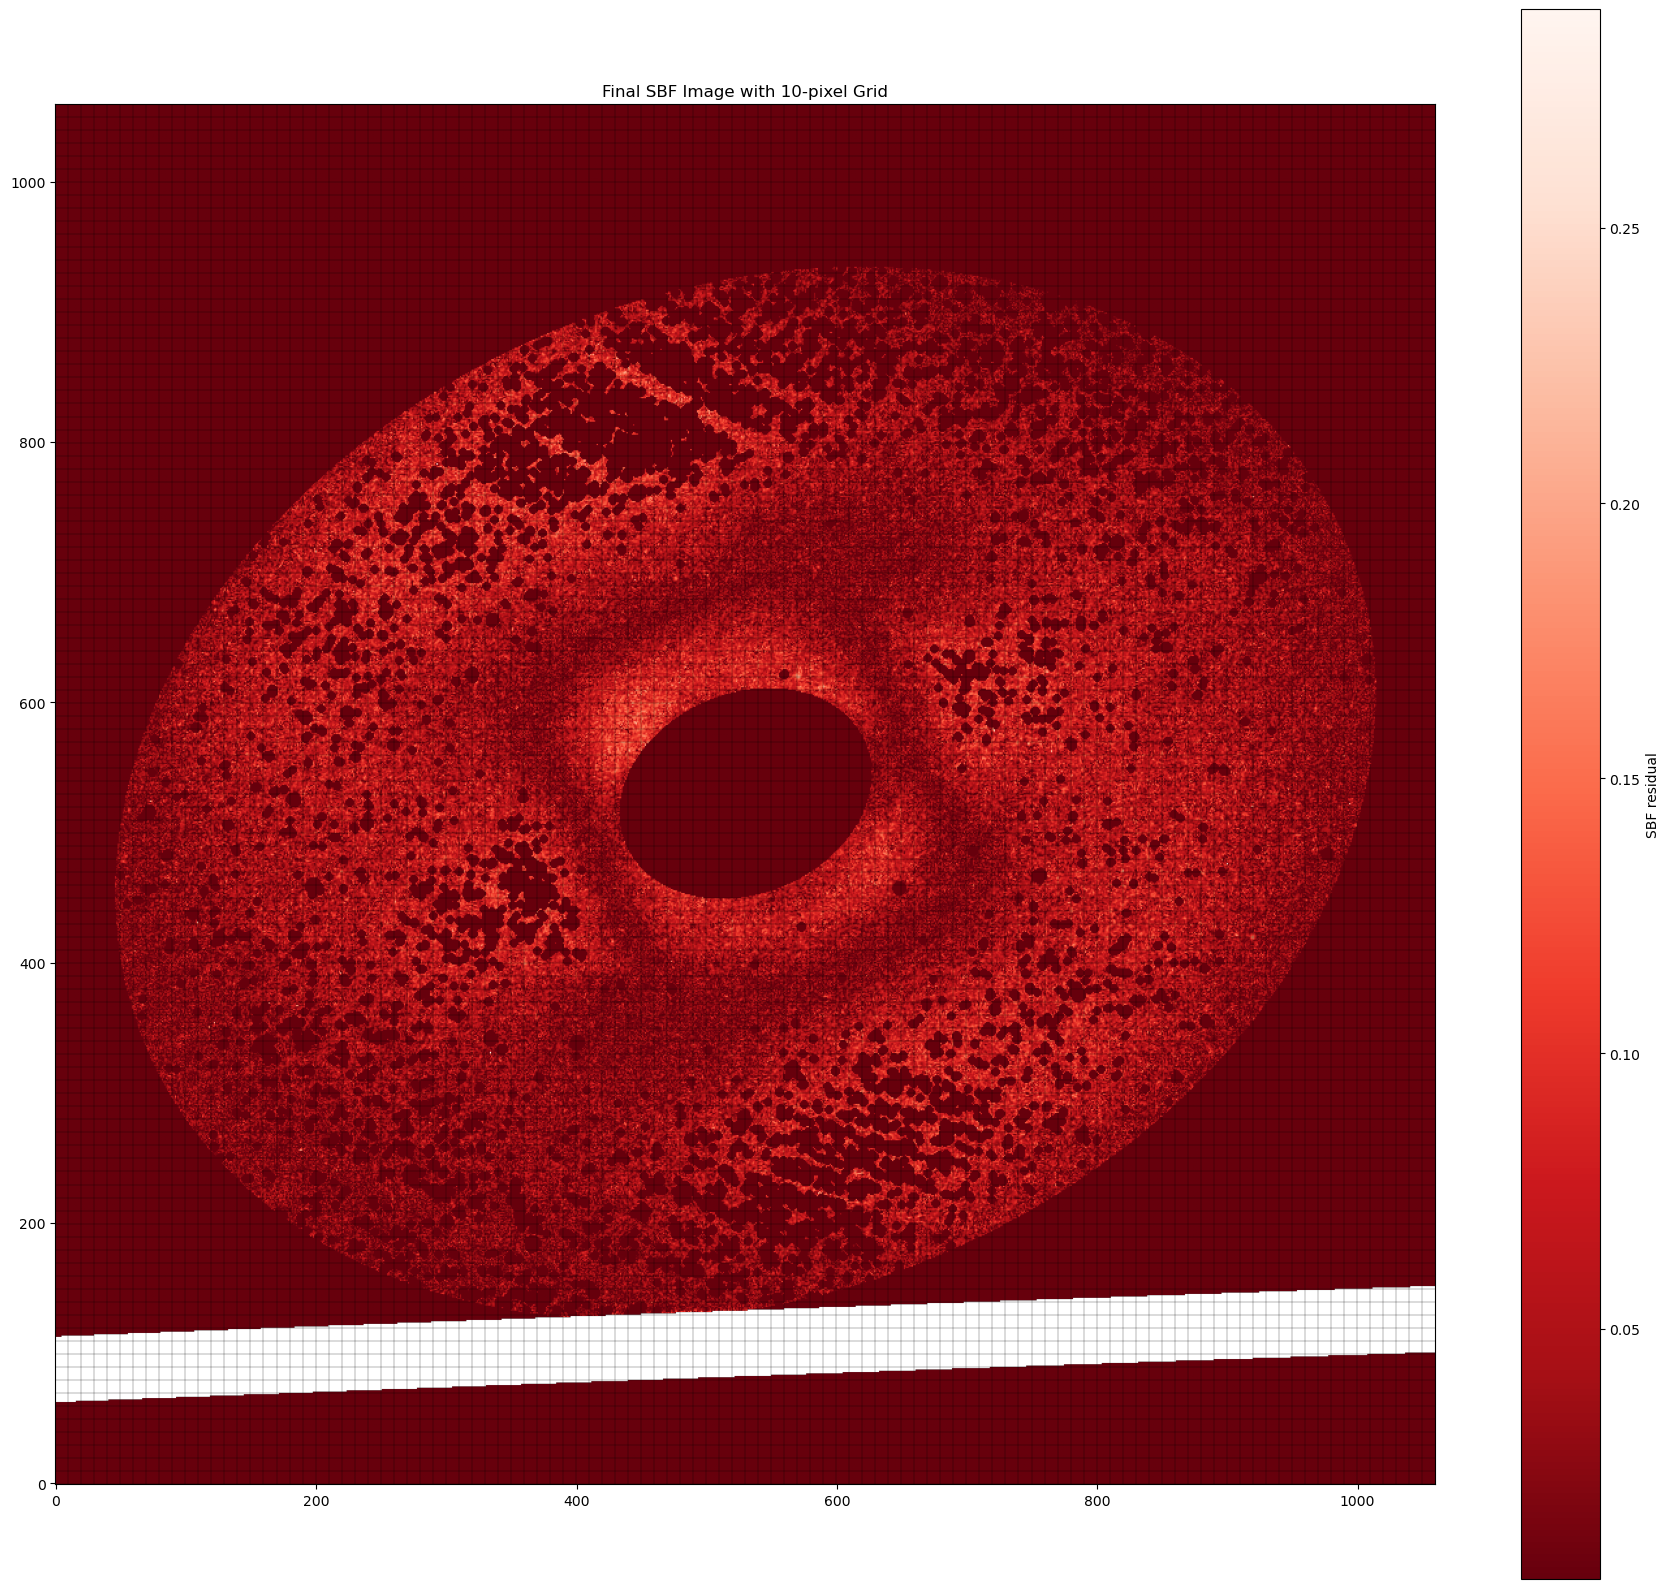

In [23]:
# =================================================
# ANNULAR ELLIPTICAL MASKING (NEW METHOD)
# =================================================

# --- parameters ---
annulus_width = 8        # pixels along major axis
nsigma_clip   = 2
mask_radius   = 1.5      # circular mask radius (diameter = 5 px)

# normalized residual (correct SBF quantity)
norm_resid = residual_cropped / model_cropped**0.5

ny, nx = norm_resid.shape
yy, xx = np.mgrid[0:ny, 0:nx]

# galaxy geometry (already fitted earlier)
# x0_s, y0_s, q, theta_s

cos_t = np.cos(theta_s)
sin_t = np.sin(theta_s)

xp = xx - x0_s
yp = yy - y0_s

# rotate into galaxy frame
x_rot =  cos_t * xp + sin_t * yp
y_rot = -sin_t * xp + cos_t * yp

# elliptical radius
R_ell = np.sqrt(x_rot**2 + (y_rot / q)**2)

# initialize mask
source_mask = np.zeros_like(norm_resid, dtype=bool)

# annulus range
R_min = np.min(R_ell[annulus_mask])
R_max = np.max(R_ell[annulus_mask])

annuli_edges = np.arange(R_min, R_max, annulus_width)

for R0 in annuli_edges:

    ann = (
        (R_ell >= R0) &
        (R_ell < R0 + annulus_width) &
        annulus_mask
    )

    if np.sum(ann) < 20:
        continue

    mu  = np.mean(norm_resid[ann])
    sig = np.std(norm_resid[ann])

    bad = ann & (norm_resid > mu + nsigma_clip * sig)

    ys, xs = np.where(bad)

    for yb, xb in zip(ys, xs):
        r = np.sqrt((xx - xb)**2 + (yy - yb)**2)
        source_mask |= (r <= mask_radius)

# dilate to cover PSF wings
source_mask = binary_dilation(source_mask, iterations=2)

# =================================================
# MANUAL MASKING (USER ARRAYS)
# =================================================
manual_positions = [
  # (y, x) in CROPPED coordinates
]

manual_radii = [

]

manual_mask = np.zeros_like(source_mask, dtype=bool)

for (y0, x0), r0 in zip(manual_positions, manual_radii):
    r = np.sqrt((xx - x0)**2 + (yy - y0)**2)
    manual_mask |= (r <= r0)

manual_mask = binary_dilation(manual_mask, iterations=2)

# combine AUTO + MANUAL
source_mask |= manual_mask

# -------------------------------------------------
# Combine with annulus mask
# -------------------------------------------------
final_mask = annulus_mask & (~source_mask)

# -------------------------------------------------
# Apply final mask (FFT-safe)
# -------------------------------------------------
sbf_image = np.zeros_like(norm_resid)
sbf_image[final_mask] = norm_resid[final_mask]

# =================================================
# PLOTTING / SANITY CHECKS (UNCHANGED)
# =================================================
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.title("Normalized residual")
plt.imshow(norm_resid, origin="lower", cmap="Reds_r",
           vmin=vmin, vmax=vmax)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Source mask (annular + manual)")
plt.imshow(source_mask, origin="lower", cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Final SBF image (FFT input)")
plt.imshow(sbf_image, origin="lower", cmap="Reds_r",
           vmin=vmin, vmax=vmax)
plt.colorbar()

plt.tight_layout()
plt.show()

# -------------------------------------------------
# Grid visualization (10-pixel grid)
# -------------------------------------------------
plt.figure(figsize=(18, 16))
plt.imshow(np.abs(sbf_image), origin="lower", cmap="Reds_r",
           vmin=vmin, vmax=0.005)

ny, nx = sbf_image.shape

for xg in range(0, nx, 10):
    plt.axvline(xg - 0.5, color="k", lw=0.2)

for yg in range(0, ny, 10):
    plt.axhline(yg - 0.5, color="k", lw=0.2)

plt.colorbar(label="SBF residual")
plt.title("Final SBF Image with 10-pixel Grid")
plt.tight_layout()
plt.show()



### Do the fourier transform to get the power spectrum:

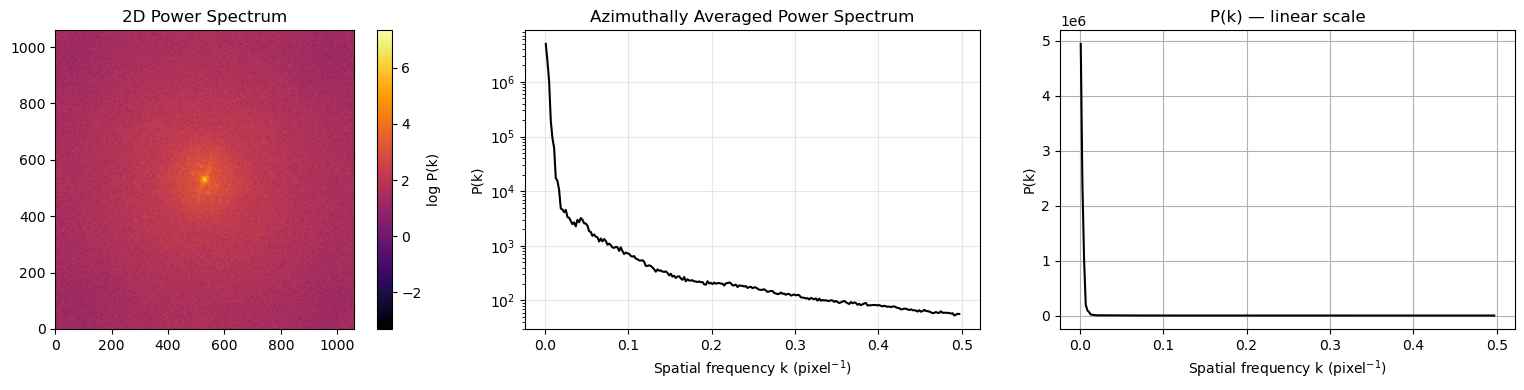

In [24]:
# -------------------------------------------------
# 1. Apply window function (Removes edge discontinuities by making it smootthly decrease to 0)
# -------------------------------------------------
ny, nx = sbf_image.shape

window = np.hanning(ny)[:, None] * np.hanning(nx)[None, :]
sbf_win = sbf_image * window

# -------------------------------------------------
# 2. 2D FFT and power spectrum
# -------------------------------------------------
F = np.fft.fft2(sbf_win)
F = np.fft.fftshift(F)          # center zero frequency
P2D = np.abs(F)**2

# -------------------------------------------------
# 3. Build k-grid (CORRECT: units = 1/pixel)
# -------------------------------------------------
ky = np.fft.fftfreq(ny, d=1.0)   # pixel^-1
kx = np.fft.fftfreq(nx, d=1.0)

ky = np.fft.fftshift(ky)
kx = np.fft.fftshift(kx)

KX, KY = np.meshgrid(kx, ky)
k = np.sqrt(KX**2 + KY**2)       # |k| in pixel^-1

# -------------------------------------------------
# 4. Azimuthal averaging (Nyquist-limited)
# -------------------------------------------------
k_nyq = 0.5          # Nyquist frequency (pixel^-1)
dk = 0.002           # bin width in pixel^-1

k_bins = np.arange(0.0, k_nyq, dk)

Pk = np.zeros(len(k_bins) - 1)
k_cent = np.zeros(len(Pk))

for i in range(len(Pk)):
    sel = (k >= k_bins[i]) & (k < k_bins[i+1])
    if np.any(sel):
        Pk[i] = P2D[sel].mean()
        k_cent[i] = 0.5 * (k_bins[i] + k_bins[i+1])

# remove empty bins
good = Pk > 0
Pk = Pk[good]
k_cent = k_cent[good]

# -------------------------------------------------
# 5. Plot results
# -------------------------------------------------
plt.figure(figsize=(16, 4))

# --- 2D Power Spectrum ---
plt.subplot(1, 3, 1)
plt.title("2D Power Spectrum")
plt.imshow(np.log10(P2D + 1e-12), origin="lower", cmap="inferno")
plt.colorbar(label="log P(k)")

# --- Azimuthal average (log scale) ---
plt.subplot(1, 3, 2)
plt.title("Azimuthally Averaged Power Spectrum")
plt.plot(k_cent, Pk, 'k-')
plt.yscale("log")
plt.xlabel("Spatial frequency k (pixel$^{-1}$)")
plt.ylabel("P(k)")
plt.grid(alpha=0.3)

# --- Azimuthal average (linear scale) ---
plt.subplot(1, 3, 3)
plt.title("P(k) — linear scale")
plt.plot(k_cent, Pk, 'k-')
plt.xlabel("Spatial frequency k (pixel$^{-1}$)")
plt.ylabel("P(k)")
plt.grid()


plt.tight_layout()
plt.show()

# -------------------------------------------------



SBF Power Spectrum Fit:
P0 (SBF amplitude) = 4.250e+01 ± 9.204e-01
P1 (white noise)  = 1.064e+02 ± 7.255e+00
Fitting range     = 0.08 ≤ k ≤ 0.25 pixel⁻¹


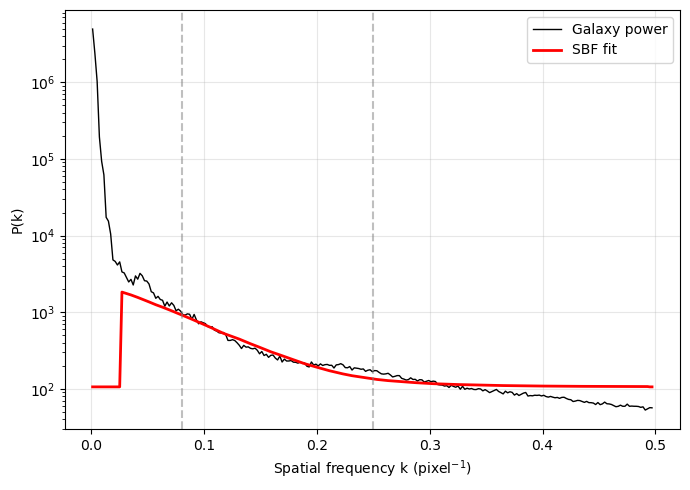

In [25]:
# -------------------------------------------------
# 6. Load PSF power spectrum from CSV
# -------------------------------------------------
psf_file = "psf_power_814.csv"
psf_df = pd.read_csv(psf_file)

k_psf = psf_df["k_pixel_inv"].values
P_psf = psf_df["PSF_power"].values


# -------------------------------------------------
# 7. Interpolate PSF power onto galaxy k-grid
# -------------------------------------------------
psf_interp = interp1d(
    k_psf,
    P_psf,
    kind="linear",
    bounds_error=False,
    fill_value=0.0
)

P_psf_on_gal = psf_interp(k_cent)


# -------------------------------------------------
# 8. Choose fitting range (CRITICAL & STABLE)
# -------------------------------------------------
kmin = 0.08
kmax = 0.25

fit_sel = (k_cent >= kmin) & (k_cent <= kmax)

k_fit  = k_cent[fit_sel]
Pk_fit = Pk[fit_sel]
Ppsf_fit = P_psf_on_gal[fit_sel]


# -------------------------------------------------
# 9. Normalize PSF in the FITTING BAND ONLY
#     (this avoids low-k bias)
# -------------------------------------------------
psf_norm = np.trapezoid(Ppsf_fit, k_fit)   # band-limited integral
P_psf_on_gal /= psf_norm
Ppsf_fit     /= psf_norm


# -------------------------------------------------
# 10. Define SBF power-spectrum model
# -------------------------------------------------
def sbf_model(k, P0, P1):
    return P0 * Ppsf_fit + P1


# -------------------------------------------------
# 11. Fit for P0 and P1 (ENFORCE POSITIVITY)
# -------------------------------------------------
p0 = [np.max(Pk_fit), np.median(Pk_fit[-10:])]  # initial guess

bounds = (
    [0.0, 0.0],          # lower bounds: P0 >= 0, P1 >= 0
    [np.inf, np.inf]     # upper bounds
)

popt, pcov = curve_fit(
    sbf_model,
    k_fit,
    Pk_fit,
    p0=p0,
    bounds=bounds
)

P0, P1 = popt
P0_err, P1_err = np.sqrt(np.diag(pcov))



# -------------------------------------------------
# 12. Print results
# -------------------------------------------------
print("\nSBF Power Spectrum Fit:")
print(f"P0 (SBF amplitude) = {P0:.3e} ± {P0_err:.3e}")
print(f"P1 (white noise)  = {P1:.3e} ± {P1_err:.3e}")
print(f"Fitting range     = {kmin:.2f} ≤ k ≤ {kmax:.2f} pixel⁻¹")


# -------------------------------------------------
# 13. Plot fit over data
# -------------------------------------------------
P_model = P0 * P_psf_on_gal + P1

plt.figure(figsize=(7, 5))
plt.plot(k_cent, Pk, "k", lw=1, label="Galaxy power")
plt.plot(k_cent, P_model, "r", lw=2, label="SBF fit")

plt.axvline(kmin, color="gray", ls="--", alpha=0.5)
plt.axvline(kmax, color="gray", ls="--", alpha=0.5)

plt.yscale("log")
plt.xlabel("Spatial frequency k (pixel$^{-1}$)")
plt.ylabel("P(k)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


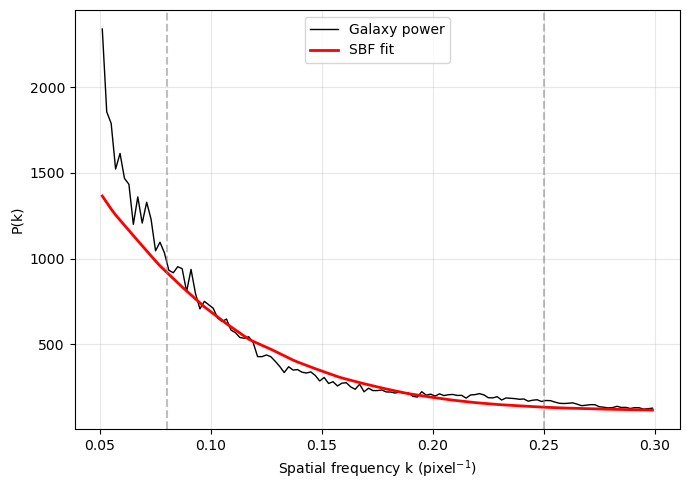

In [26]:
plt.figure(figsize=(7, 5))
plt.plot(k_cent[25:150], Pk[25:150], "k", lw=1, label="Galaxy power")
plt.plot(k_cent[25:150], P_model[25:150], "r", lw=2, label="SBF fit")

plt.axvline(kmin, color="gray", ls="--", alpha=0.5)
plt.axvline(kmax, color="gray", ls="--", alpha=0.5)

# plt.yscale("log")
plt.xlabel("Spatial frequency k (pixel$^{-1}$)")
plt.ylabel("P(k)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

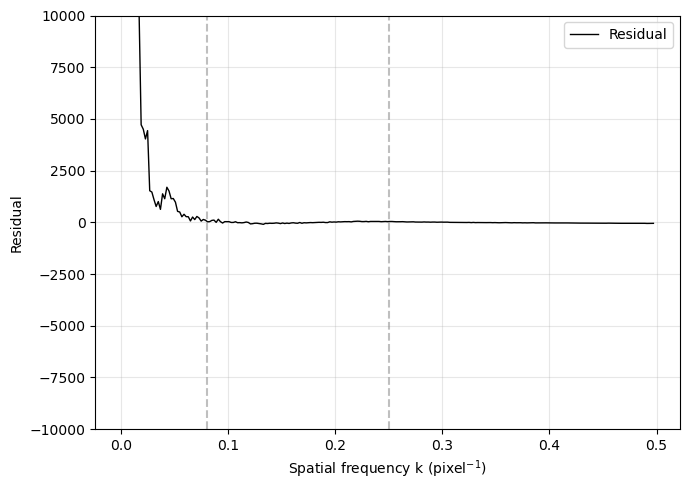

In [27]:
plt.figure(figsize=(7, 5))
plt.plot(k_cent, Pk-(P_model), "k", lw=1, label="Residual")

plt.axvline(kmin, color="gray", ls="--", alpha=0.5)
plt.axvline(kmax, color="gray", ls="--", alpha=0.5)

plt.xlabel("Spatial frequency k (pixel$^{-1}$)")
plt.ylabel("Residual")
plt.legend()
plt.ylim(-10000, 10000)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

$$
m_{\mathrm{ZP}}
=
-2.5 \log_{10}\!\left(\mathrm{PHOTFLAM}\right)
+ PHOTZPT
$$

$$
\bar{m}_{\lambda}
=
-2.5 \log_{10}\!\left(P_0\right)
+ m_{\mathrm{ZP}}
+ 2.5 \log_{10}\!\left(t_{\mathrm{exp}}\right)
$$


In [28]:
m_zp = -2.5*np.log10(PHOTFLAM) + PHOTZPT

m_lambda = -2.5*np.log10(P0) + m_zp + 2.5*np.log10(exp_time)
dm = (2.5 / np.log(10)) * (P0_err / P0)

print(f"Apparent SBF magnitude = {m_lambda:.2f} ± {dm:.2f} (STMAG)")


Apparent SBF magnitude = 28.88 ± 0.02 (STMAG)


## Intensity vs radial distance in R0 units:

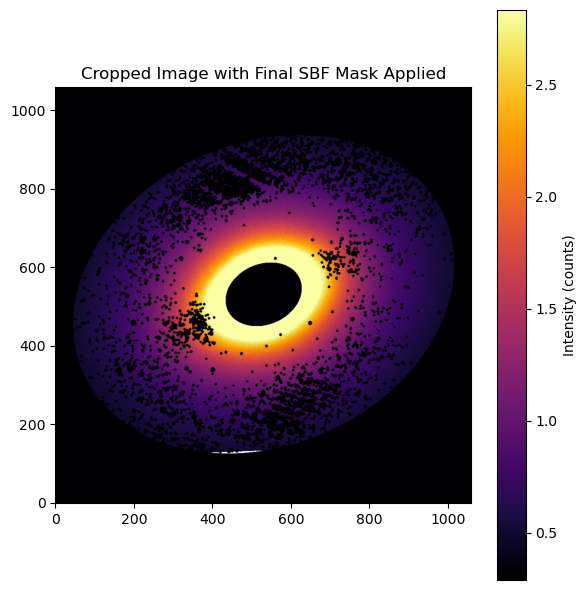

Pixels used for color: 448182
Sérsic center (cropped frame): 530.4217553194183 530.9194161389028


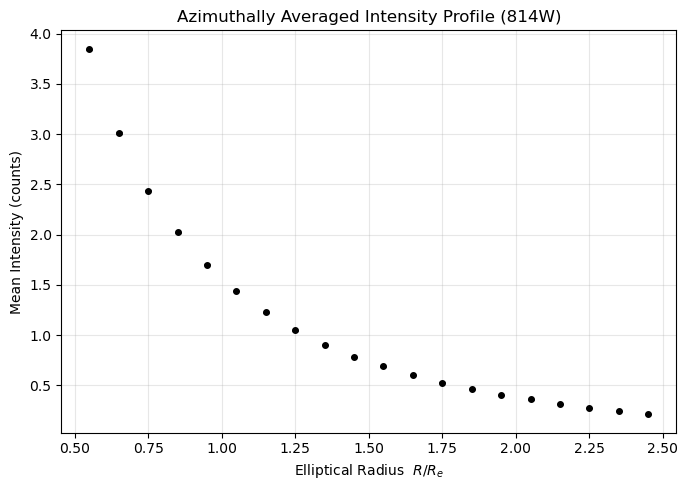

Saved → 475Wint.csv
Radial bins saved: 20
Min pixels/bin: 10640


In [29]:
# ============================================================
# COLOR MEASUREMENT — FINAL, CONSISTENT IMPLEMENTATION
# ============================================================

# ------------------------------------------------------------
# 1. Apply FINAL MASK to CROPPED SCIENCE IMAGE
# ------------------------------------------------------------
sci_for_color = np.zeros_like(sci_cropped_masked.data)
sci_for_color[final_mask] = sci_cropped_masked.data[final_mask]

plt.figure(figsize=(6, 6))
plt.title("Cropped Image with Final SBF Mask Applied")
plt.imshow(sci_for_color, origin="lower",cmap="inferno", vmin = vmin, vmax = vmax)
plt.colorbar(label="Intensity (counts)")
plt.tight_layout()
plt.show()

print("Pixels used for color:", np.sum(final_mask))


# ============================================================
# AZIMUTHALLY AVERAGED INTENSITY PROFILE (FINAL VERSION)
# ============================================================

# ------------------------------------------------------------
# 0. Sérsic center in CROPPED coordinates (CRITICAL)
# ------------------------------------------------------------
x0_c = x0_s - x_min
y0_c = y0_s - y_min

print("Sérsic center (cropped frame):", x0_c, y0_c)


# ------------------------------------------------------------
# 1. Coordinate grid (cropped image)
# ------------------------------------------------------------
ny, nx = sci_cropped_masked.shape
yy, xx = np.mgrid[0:ny, 0:nx]


# ------------------------------------------------------------
# 2. Elliptical radius map (Sérsic geometry)
# ------------------------------------------------------------
xp = xx - x0_c
yp = yy - y0_c

ct = np.cos(-theta_s)
st = np.sin(-theta_s)

x_rot =  ct * xp + st * yp
y_rot = -st * xp + ct * yp

R_ell = np.sqrt(x_rot**2 + (y_rot / q)**2)   # pixels


# ------------------------------------------------------------
# 3. Annulus definition (0.5 Re → 2.5 Re)
# ------------------------------------------------------------
R_min = 0.5 * Re
R_max = 2.5 * Re
dR    = 0.1 * Re

R_edges = np.arange(R_min, R_max + dR, dR)
R_cent  = 0.5 * (R_edges[:-1] + R_edges[1:])


# ------------------------------------------------------------
# 4. Value-based pixel rejection threshold
# ------------------------------------------------------------
I_min = 0.5     # counts (tune if needed)


# ------------------------------------------------------------
# 5. Azimuthal averaging over FULL elliptical annuli
# ------------------------------------------------------------
mean_I = []
std_I  = []
npix   = []

img = sci_cropped_masked.data

for R0, R1 in zip(R_edges[:-1], R_edges[1:]):

    annulus = (R_ell >= R0) & (R_ell < R1)

    values = img[annulus]

    # ---- CLEANING ----
    values = values[np.isfinite(values)]
    # values = values[values > I_min]

    if values.size < 100:
        mean_I.append(np.nan)
        std_I.append(np.nan)
        npix.append(0)
        continue

    mean_I.append(np.mean(values-c))           ##Background subtraction
    std_I.append(np.std(values-c) / np.sqrt(values.size))
    npix.append(values.size)


mean_I = np.array(mean_I)
std_I  = np.array(std_I)
npix   = np.array(npix)

R_over_Re = R_cent / Re


# ------------------------------------------------------------
# 6. Plot intensity profile
# ------------------------------------------------------------
plt.figure(figsize=(7, 5))
plt.errorbar(
    R_over_Re,
    mean_I,
    yerr=std_I,
    fmt="ko",
    ms=4,
    lw=1,
    capsize=2
)

plt.xlabel(r"Elliptical Radius  $R / R_e$")
plt.ylabel("Mean Intensity (counts)")
plt.title("Azimuthally Averaged Intensity Profile (814W)")
plt.grid(alpha=0.3)
plt.tight_layout()


plt.show()


# ------------------------------------------------------------
# 7. Save to CSV
# ------------------------------------------------------------
df = pd.DataFrame({
    "R_over_Re": R_over_Re,
    "Mean_Intensity": mean_I,
    "Std_Intensity": std_I,
    "Npix": npix
})

df = df[np.isfinite(df["Mean_Intensity"])]

outfile = "475Wint.csv"
df.to_csv(outfile, index=False)

print(f"Saved → {outfile}")
print("Radial bins saved:", len(df))
print("Min pixels/bin:", np.min(df["Npix"]))


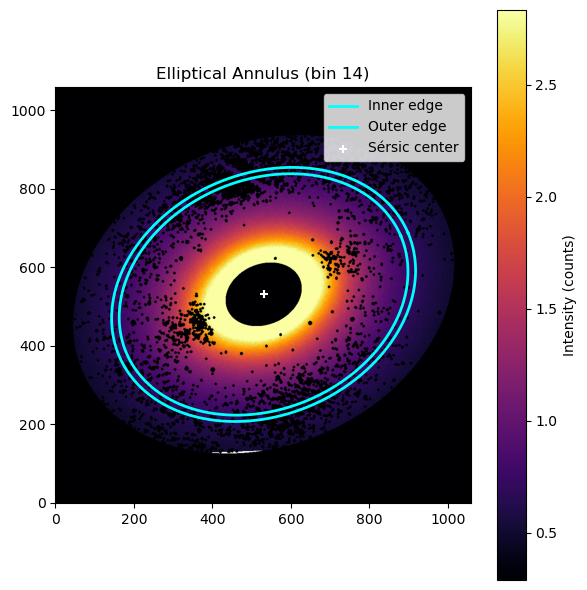

In [30]:
# ============================================================
# VISUALIZE A SPECIFIC ELLIPTICAL ANNULUS ON THE IMAGE
# (Using R_edges[10])
# ============================================================

idx = 14
R1 = R_edges[idx]
R2 = R_edges[idx + 1]

theta = np.linspace(0, 2*np.pi, 1000)

# --- ellipse in galaxy frame ---
x1 = R1 * np.cos(theta)
y1 = R1 * q * np.sin(theta)

x2 = R2 * np.cos(theta)
y2 = R2 * q * np.sin(theta)

# --- rotate + shift to image frame ---
ct = np.cos(-theta_s)
st = np.sin(-theta_s)

def to_image_frame(xe, ye):
    xr =  ct * xe + st * ye + x0_c
    yr = -st * xe + ct * ye + y0_c
    return xr, yr

x1p, y1p = to_image_frame(x1, y1)
x2p, y2p = to_image_frame(x2, y2)


# ------------------------------------------------------------
# Plot on cropped science image
# ------------------------------------------------------------
plt.figure(figsize=(6, 6))
plt.imshow(sci_for_color, origin="lower",
           cmap="inferno", vmin = vmin, vmax = vmax)
plt.colorbar(label="Intensity (counts)")

plt.plot(x1p, y1p, "cyan", lw=2, label="Inner edge")
plt.plot(x2p, y2p, "cyan", lw=2, label="Outer edge")

plt.scatter(x0_c, y0_c, c="white", s=40, marker="+", label="Sérsic center")

plt.title(f"Elliptical Annulus (bin {idx})")
plt.legend()
plt.tight_layout()
plt.show()
